# Introduction to ConvNets (CNN) in keras

Now that you have some idea of how to use keras, we will use that to build a convolutional neural network! It is the main type of network that we will utilize to program our self-driving cars.


# The problem/dataset

As our toy problem, we will look into CIFAR10, this is one of a good, publicly open dataset that can be used to test your model for general object classification performance. In this dataset contains 60K images in 32x32 resolution. Not only does this have a good amount of data for proper learning to take place, it has multiple classes to practice multi-class classification task.

Citation: Learning Multiple Layers of Features from Tiny Images, Alex Krizhevsky, 2009.

In [1]:
#imports
from keras.models import Model
from keras.layers import *
from keras import applications
from keras.optimizers import *
from keras.callbacks import *
import keras.backend as K
from glob import glob

Using TensorFlow backend.


# Dataset

We will first load our dataset. The process is as follows:

## Mac/Linux-based OS
1. Download the python version for CIFAR-10 from [here](https://www.cs.toronto.edu/~kriz/cifar.html)
2. Uncompress the .tar.gz file

## Windows
1. Download the python version for CIFAR-10 from [here](https://www.cs.toronto.edu/~kriz/cifar.html)
2. 


In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_data(address):
    data = []
    for path in glob(address + "/*"):
        tmp = unpickle(path)
        data.append(tmp)
    if (len(data)==0):
        print("Oh no! data is None, which means it failed to load.")
    return data

In [3]:
train_data = load_data("/Users/Hal/ARC_tutorial/CIFAR_10/train")

In [68]:
def extract_xy(input_list, x, y):
    for i in range(len(input_list)):
        batch = input_list[i]
        labels = batch[b'labels']
        data = np.array(batch[b'data']) #3072 length vector
        #data = np.reshape(data, (-1,32,32,3))
        data = np.reshape(data,(10000, 3, 32, 32)).transpose(0,2,3,1)
        x[i*len(labels):(i+1)*len(labels),:,:,:] = data
        y[i*len(labels):(i+1)*len(labels)] = labels
    return x,y

In [69]:
x_train, y_train = extract_xy(train_data,np.empty((50000,32,32,3)), np.empty(50000))

In [70]:
#Here we can check our data shapes to confirm the data has been processed
print(x_train.shape, y_train.shape)

(50000, 32, 32, 3) (50000,)


# Visualization

What's good at starting numbers and matrices? Hence we look at some ways to visualize our data before modelling. This is known as part of a process called Explanatory Data Analysis (EDA) where the engineer can look at the data for better understanding of it overall, before diving into crunching numbers.


## Look at example Images
In the case of Computer Vision, it is helpful for us to actually look at some of the images and some general information about the data. 

In [8]:
import matplotlib.pyplot as plt
plt.style.use("seaborn")

In [82]:
#choose any ith image
idx = np.random.choice(np.arange(50000))

#get first image
sample = x_train[idx,:,:,:]
tmp = sample
sample.dtype

dtype('float64')

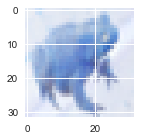

In [90]:
figure = plt.figure(figsize = (2,2))
plt.imshow((sample * 255).astype(np.uint8), interpolation='nearest')

Unfortunately, the images do not look to well, since they are small in size (32 by 32). Nonetheless, this can give us physical images to look at.

## Y(output class) distribution

We can also look at the labels to get some ideas about our data.

In [93]:
class_count = np.zeros(10)

for label in y_train:
    class_count[int(label) - 1] += 1

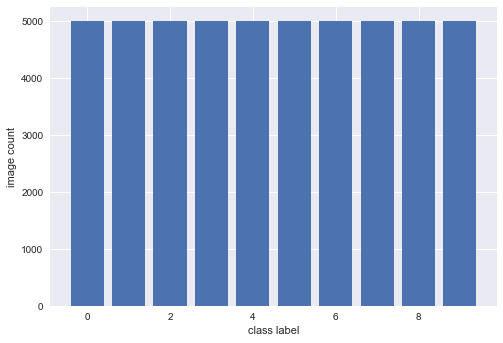

In [97]:
plt.bar(np.arange(10),class_count)
plt.ylabel("image count")
plt.xlabel("class label")
plt.show()

In this specific data, the providers of data ensured that we are given exactly 5K training image per class, and 1K image per class in the testing dataset. However, in real life scenario, this will come useful in giving yourself general understanding of distribution of data depending on classes. For instance, if a class had significantly more data then others, this may lead to be problem, which should be fixed.

# Model (from scratch)

In [122]:
def build_model():
    input_layer = layers.Input(shape=(32,32,3))
    conv1 = Conv2D(32, (3,3), strides=1, activation='relu', padding = 'same') (input_layer)
    pool1 = MaxPooling2D((2,2))(conv1)
    conv2 = Conv2D(64, (3,3), strides=1, activation='relu', padding = 'same') (pool1)
    pool2 = MaxPooling2D((2,2))(conv2)
    conv3 = Conv2D(128, (3,3), strides=1, activation='relu', padding = 'same') (pool2)
    pool3 = MaxPooling2D((2,2))(conv3)
    conv4 = Conv2D(256, (3,3), strides=1, activation='relu', padding = 'same') (pool3)
    glob = GlobalMaxPooling2D() (conv4)
    fc1 = Dense(512) (glob)
    fc1 = Dropout(rate= 0.4) (fc1)
    fc2 = Dense(1024) (fc1)
    fc2 = Dropout(rate= 0.4)(fc2)
    fc3 = Dense(10, activation = 'softmax') (fc2)
    model = Model(input_layer, fc3)
    model.summary()
    return model

# Model (from keras.applications)

In [99]:
def call_xception():
    model = applications.xception()
    model.compile(optimizer = Adam(), loss = 'categorical_crossentropy', metrics = ['acc'])
    model.summary()
    return model

# Compile, train, and test

In [100]:
from sklearn.model_selection import train_test_split

#Since test data is separetly provided, we do split for train/val
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,test_size=0.4, random_state=42)
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

(30000, 32, 32, 3) (20000, 32, 32, 3) (30000,) (20000,)


In [101]:
#load our training data
train_data = load_data("/Users/Hal/ARC_tutorial/CIFAR_10/test")
x_test, y_test = extract_xy(train_data,np.empty((10000,32,32,3)), np.empty(10000))

In [113]:
#scale all our data
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_val /= 255
x_test /= 255

In [119]:
from keras.utils import to_categorical

num_classes = 10
# Convert class vectors to binary class matrices.
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)

In [120]:
def train_and_eval(type = 'custom'):
    if (type=='custom'):
        model = build_model()
        model.compile(optimizer = Adam(), loss = 'categorical_crossentropy', metrics = ['acc'])
        model.fit(x_train, y_train, batch_size = 16, epochs = 30, shuffle = True, validation_data=(x_val,y_val),
                  verbose = 1)
        model.evaluate(x_test, y_test, verbose = 1)

In [123]:
train_and_eval()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 4, 4, 128)         0         
__________

KeyboardInterrupt: 

# Graphs!

Congratulations! You now used various CNN models for the image classification task with Keras.